# Machine Learning

--- 
## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

sb.set()

--- 
## Load Data

In [2]:
path = '../data/'
X = pd.read_csv(path+'predictors.csv')
y = pd.read_csv(path+'response.csv')

In [3]:
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.505892,1.054756,-1.362277,-0.644525,-0.142325,-0.434038,-0.284919,0.817412,1.414449,-0.616944,-1.005353
1,-0.231910,2.125547,-1.362277,0.916965,1.328430,1.199528,1.025208,0.185197,-0.950323,0.458296,-0.601346
2,-0.231910,1.411686,-1.142510,0.247755,0.927315,0.032695,0.509097,0.311640,-0.492625,0.189486,-0.601346
3,2.096930,-1.443756,1.714462,-0.644525,-0.209177,0.266062,0.747302,0.943855,-1.255455,-0.437737,-0.601346
4,-0.505892,0.816803,-1.362277,-0.867595,-0.209177,-0.200672,-0.046714,0.817412,1.414449,-0.616944,-1.005353


In [4]:
y.head()

,quality
0,1
1,1
2,1
3,1
4,1


In [5]:
# m samples, n features
m, n = X.shape
print(m, n)

985 11


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

--- 
## Decision Tree

### Build Model

In [7]:
from sklearn.tree import DecisionTreeClassifier

# use a smaller dataset to find optimal max_depth
X_train_try, X_test_try, y_train_try, y_test_try = train_test_split(X_train, y_train, train_size=0.7)
for depth in range(2, 10):
    model = DecisionTreeClassifier(max_depth=depth)
    model.fit(X_train_try, y_train_try)
    print(f"For depth {depth}, train accuracy {model.score(X_train_try, y_train_try):.4f}, test accuracy {model.score(X_test_try, y_test_try):.4f}.")

For depth 2, train accuracy 0.8512, test accuracy 0.8101.
For depth 3, train accuracy 0.8857, test accuracy 0.8186.
For depth 4, train accuracy 0.9020, test accuracy 0.8143.
For depth 5, train accuracy 0.9238, test accuracy 0.8059.
For depth 6, train accuracy 0.9310, test accuracy 0.8101.
For depth 7, train accuracy 0.9510, test accuracy 0.8186.
For depth 8, train accuracy 0.9564, test accuracy 0.7932.
For depth 9, train accuracy 0.9691, test accuracy 0.8017.


In [8]:
# choose 4 as max_depth
model = DecisionTreeClassifier(max_depth=4)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

### Plot Decision Tree

[Text(0.3958333333333333, 0.9, 'alcohol <= 0.762\ngini = 0.281\nsamples = 788\nvalue = [27, 660, 101]\nclass = 1'),
 Text(0.125, 0.7, 'pH <= -2.285\ngini = 0.186\nsamples = 597\nvalue = [26, 537, 34]\nclass = 1'),
 Text(0.08333333333333333, 0.5, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 3]\nclass = 2'),
 Text(0.16666666666666666, 0.5, 'chlorides <= -1.112\ngini = 0.178\nsamples = 594\nvalue = [26, 537, 31]\nclass = 1'),
 Text(0.08333333333333333, 0.3, 'volatile acidity <= -0.879\ngini = 0.513\nsamples = 43\nvalue = [6, 28, 9]\nclass = 1'),
 Text(0.041666666666666664, 0.1, 'gini = 0.524\nsamples = 15\nvalue = [1, 5, 9]\nclass = 2'),
 Text(0.125, 0.1, 'gini = 0.293\nsamples = 28\nvalue = [5, 23, 0]\nclass = 1'),
 Text(0.25, 0.3, 'volatile acidity <= 2.319\ngini = 0.144\nsamples = 551\nvalue = [20, 509, 22]\nclass = 1'),
 Text(0.20833333333333334, 0.1, 'gini = 0.136\nsamples = 544\nvalue = [17, 505, 22]\nclass = 1'),
 Text(0.2916666666666667, 0.1, 'gini = 0.49\nsamples = 7\nvalue = [3, 4, 

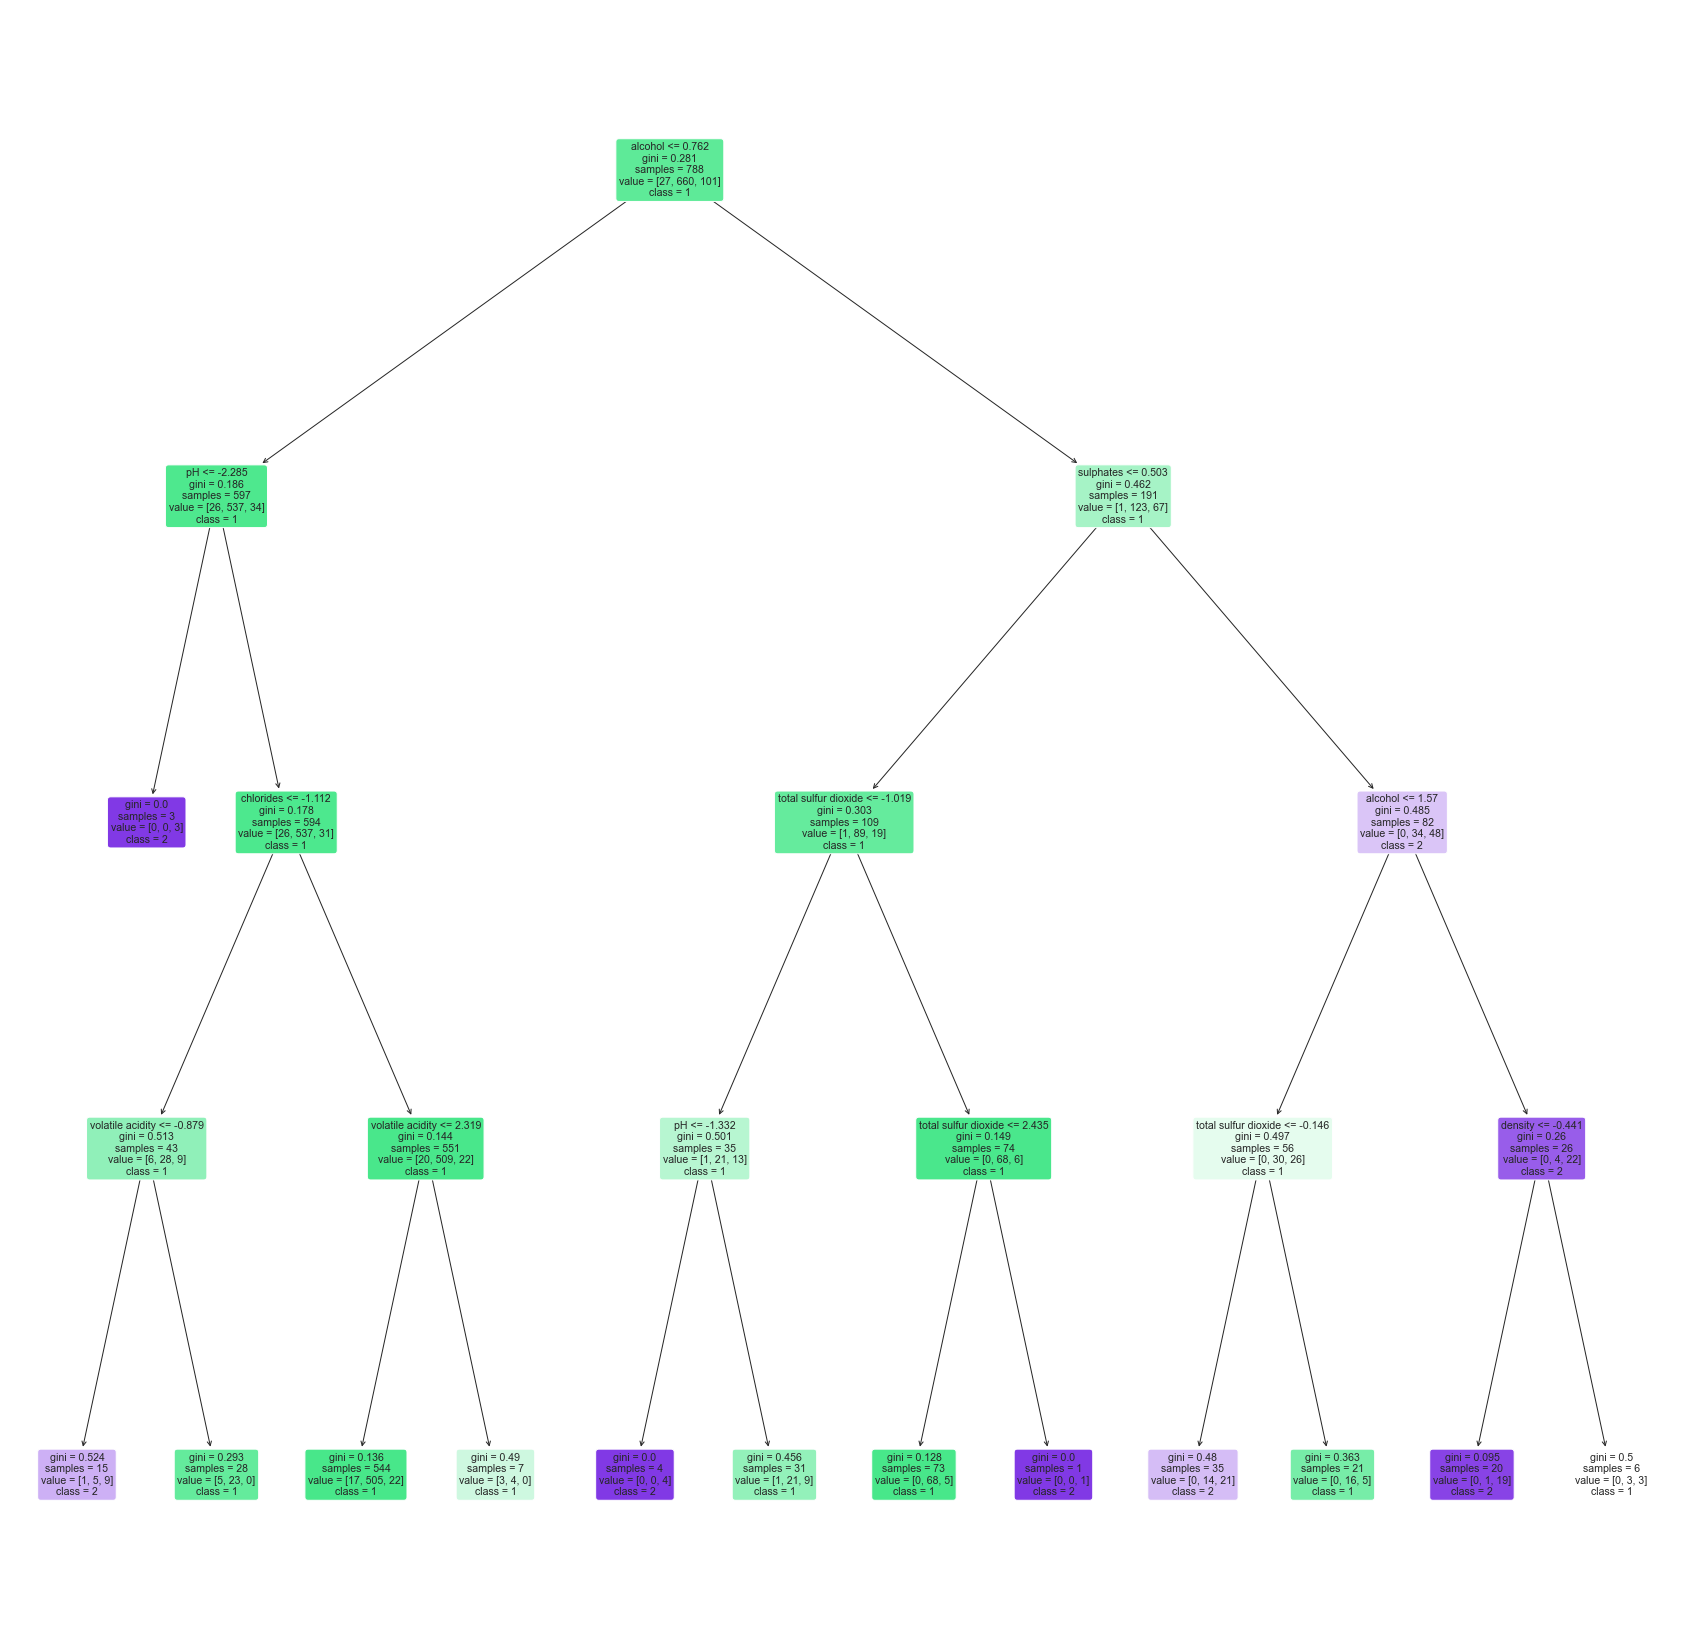

In [9]:
from sklearn.tree import plot_tree

classes = ['0', '1', '2']
f = plt.figure(figsize=(30, 30))
plot_tree(decision_tree=model, 
            filled=True,
            rounded=True,
            feature_names=X_train.columns,
            class_names=classes)

### Evaluate Model

In [10]:
# overall accuracy
print(f"For training data, accuracy={model.score(X_train, y_train)}.")
print(f"For testing data, accuracy={model.score(X_test, y_test)}.")


For training data, accuracy=0.8845177664974619.
For testing data, accuracy=0.8426395939086294.


In [11]:
from sklearn.metrics import confusion_matrix

def oneVsAllEvaluation(y_true, y_predict, plotConfusionMatrix=True)->float:
    '''
    A utility function to evaluate predicting one variable against others
    Input: actual response, predicted response, whether plot the confusion matrix or not
    Output: average accuracy
    '''
    accu_sum = 0
    for i in range(0, 3):
        y_temp = y_true.copy()
        y_temp_pred = y_predict.copy()
        for j in range(y_temp.size):
            if (y_temp.iloc[j][0] == i):
                y_temp.iloc[j][0] = 1
            else:
                y_temp.iloc[j][0] = 0
            if (y_temp_pred[j] == i):
                y_temp_pred[j] = 1
            else:
                y_temp_pred[j] = 0
        
        cm = confusion_matrix(y_temp, y_temp_pred)
        tn = cm[0][0] # True Negatives : Bad (0) predicted Bad (0)
        tp = cm[1][1] # True Positives : Good (1) predicted Good (1)
        fp = cm[0][1] # False Positives : Bad (0) predicted Good (1)
        fn = cm[1][0] # False Negatives : Good (1) predicted Bad (0)
        accu = ((tp+tn)/(tp+tn+fp+fn)) 
        accu_sum += accu
        
        print("Value {} versus others: ".format(i))
        print("Acc:\t", accu)
        print("TPR:\t", (tp/(tp + fn)))
        print("TNR:\t", (tn/(tn + fp)))
        print("FPR:\t", (fp/(fp + tn)))
        print("FNR:\t", (fn/(fn + tp)))
        print()

        if (plotConfusionMatrix):
            f = plt.figure(figsize=(5, 5))
            sb.heatmap(confusion_matrix(y_temp, y_temp_pred), 
                annot = True, fmt=".0f", annot_kws={"size": 18})
            f.text(0, 1, "Value {} versus others:".format(i))

    return accu_sum / 3 

Value 0 versus others: 
Acc:	 0.9657360406091371
TPR:	 0.0
TNR:	 1.0
FPR:	 0.0
FNR:	 1.0

Value 1 versus others: 
Acc:	 0.8857868020304569
TPR:	 0.9696969696969697
TNR:	 0.453125
FPR:	 0.546875
FNR:	 0.030303030303030304

Value 2 versus others: 
Acc:	 0.9175126903553299
TPR:	 0.5643564356435643
TNR:	 0.9694323144104804
FPR:	 0.03056768558951965
FNR:	 0.43564356435643564



0.9230118443316413

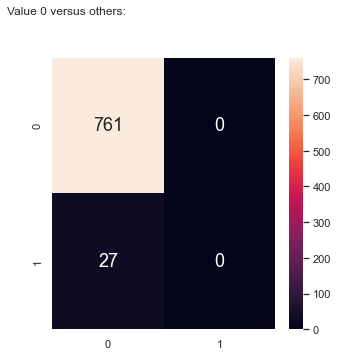

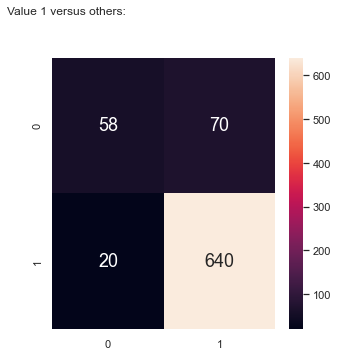

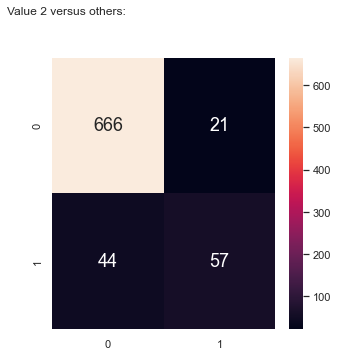

In [12]:
# Evaluation of train data
y_train_pred = model.predict(X_train)
oneVsAllEvaluation(y_train, y_train_pred)

Value 0 versus others: 
Acc:	 0.9644670050761421
TPR:	 0.0
TNR:	 1.0
FPR:	 0.0
FNR:	 1.0

Value 1 versus others: 
Acc:	 0.8426395939086294
TPR:	 0.9337349397590361
TNR:	 0.3548387096774194
FPR:	 0.6451612903225806
FNR:	 0.06626506024096386

Value 2 versus others: 
Acc:	 0.8781725888324873
TPR:	 0.4583333333333333
TNR:	 0.9364161849710982
FPR:	 0.06358381502890173
FNR:	 0.5416666666666666



0.895093062605753

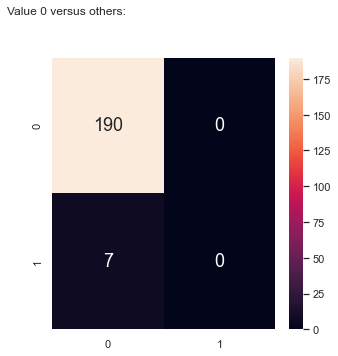

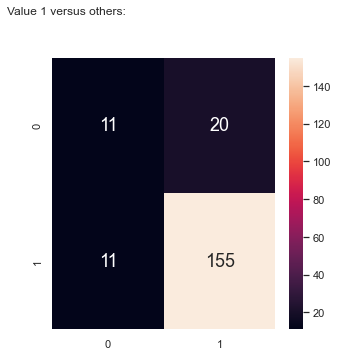

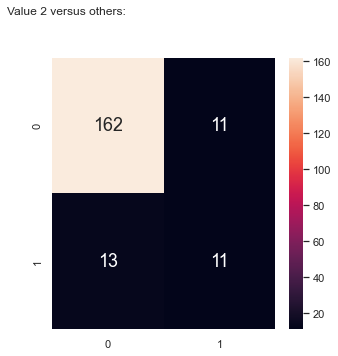

In [13]:
# Evaluation of train data
y_test_pred = model.predict(X_test)
oneVsAllEvaluation(y_test, y_test_pred)

--- 
## Stochastic Gradient Descent

In [14]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(loss='log',
                    alpha=1e-7,
                    max_iter=1e7,
                    learning_rate='adaptive',
                    eta0=10
                    )
model.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniconda/base/envs/DSAI/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(alpha=1e-07, eta0=10, learning_rate='adaptive', loss='log',
              max_iter=10000000.0)

In [15]:
# overall accuracy
print(f"For training data, accuracy={model.score(X_train, y_train)}.")
print(f"For testing data, accuracy={model.score(X_test, y_test)}.")

For training data, accuracy=0.8629441624365483.
For testing data, accuracy=0.8527918781725888.


In [16]:
# Evaluation of train data
y_train_pred = model.predict(X_train)
oneVsAllEvaluation(y_train, y_train_pred, plotConfusionMatrix=False)

Value 0 versus others: 
Acc:	 0.9657360406091371
TPR:	 0.0
TNR:	 1.0
FPR:	 0.0
FNR:	 1.0

Value 1 versus others: 
Acc:	 0.8629441624365483
TPR:	 0.9757575757575757
TNR:	 0.28125
FPR:	 0.71875
FNR:	 0.024242424242424242

Value 2 versus others: 
Acc:	 0.8972081218274112
TPR:	 0.3564356435643564
TNR:	 0.9767103347889374
FPR:	 0.023289665211062592
FNR:	 0.6435643564356436



0.9086294416243655

In [17]:
# Evaluation of train data
y_test_pred = model.predict(X_test)
oneVsAllEvaluation(y_test, y_test_pred, plotConfusionMatrix=False)

Value 0 versus others: 
Acc:	 0.9644670050761421
TPR:	 0.0
TNR:	 1.0
FPR:	 0.0
FNR:	 1.0

Value 1 versus others: 
Acc:	 0.8527918781725888
TPR:	 0.9759036144578314
TNR:	 0.1935483870967742
FPR:	 0.8064516129032258
FNR:	 0.024096385542168676

Value 2 versus others: 
Acc:	 0.8883248730964467
TPR:	 0.25
TNR:	 0.976878612716763
FPR:	 0.023121387283236993
FNR:	 0.75



0.9018612521150592

--- 
## Support Vector Machine


In [18]:
from sklearn.svm import SVC

model = SVC(kernel='rbf',
        C=1,
        gamma=1,
        )
model.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniconda/base/envs/DSAI/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1, gamma=1)

In [19]:
# overall accuracy
print(f"For training data, accuracy={model.score(X_train, y_train)}.")
print(f"For testing data, accuracy={model.score(X_test, y_test)}.")

For training data, accuracy=0.9822335025380711.
For testing data, accuracy=0.8527918781725888.


In [20]:
# Evaluation of train data
y_train_pred = model.predict(X_train)
oneVsAllEvaluation(y_train, y_train_pred, plotConfusionMatrix=False)

Value 0 versus others: 
Acc:	 0.9898477157360406
TPR:	 0.7037037037037037
TNR:	 1.0
FPR:	 0.0
FNR:	 0.2962962962962963

Value 1 versus others: 
Acc:	 0.9822335025380711
TPR:	 1.0
TNR:	 0.890625
FPR:	 0.109375
FNR:	 0.0

Value 2 versus others: 
Acc:	 0.9923857868020305
TPR:	 0.9405940594059405
TNR:	 1.0
FPR:	 0.0
FNR:	 0.0594059405940594



0.988155668358714

In [21]:
# Evaluation of test data
y_train_pred = model.predict(X_test)
oneVsAllEvaluation(y_test, y_test_pred, plotConfusionMatrix=False)

Value 0 versus others: 
Acc:	 0.9644670050761421
TPR:	 0.0
TNR:	 1.0
FPR:	 0.0
FNR:	 1.0

Value 1 versus others: 
Acc:	 0.8527918781725888
TPR:	 0.9759036144578314
TNR:	 0.1935483870967742
FPR:	 0.8064516129032258
FNR:	 0.024096385542168676

Value 2 versus others: 
Acc:	 0.8883248730964467
TPR:	 0.25
TNR:	 0.976878612716763
FPR:	 0.023121387283236993
FNR:	 0.75



0.9018612521150592